In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

plt.style.use('default')

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

In [2]:
data = pd.read_csv('data/online_retail_II_clean.csv', parse_dates=['InvoiceDate'])
data_backup = data.copy()
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total
0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
1,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50
2,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10
3,536366,22632,HAND WARMER RED RETROSPOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10
4,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.50


In [3]:
print('Customer count:', data['Customer ID'].nunique())
print('Invoice count:', data['Invoice'].nunique())

Customer count: 4131
Invoice count: 16084


In [4]:
newest = data['InvoiceDate'].max()
today = datetime.datetime.today()
old_difference = today - newest
print('old:', old_difference)

data['InvoiceDate'] += old_difference

updated_newest = data['InvoiceDate'].max()
current_difference = today - updated_newest
print('new:', current_difference)

old: 4689 days 01:58:24.691158
new: 0 days 00:00:00


In [5]:
newest = data['InvoiceDate'].max()
data['Recency'] = (newest - data['InvoiceDate']).dt.days

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

In [6]:
recency = data[['Customer ID', 'Recency']]
recency = recency.groupby('Customer ID').min()
recency.sample(5).T

Customer ID,17053,16221,13833,16012,14245
Recency,130,36,158,34,219


In [7]:
frequency = data.groupby(['Customer ID', 'Invoice']).agg({'Invoice':'count'})
# display(frequency.head(3))

frequency = frequency.groupby('Customer ID').agg({'Invoice':'count'})
frequency.columns=['Invoice Count']

frequency.nlargest(5, columns='Invoice Count').T

Customer ID,14911,12748,17841,15311,14606
Invoice Count,188,185,121,91,89


In [8]:
monetary = data.groupby('Customer ID').agg({'Total':'sum'})
monetary.nlargest(5, columns='Total').T

Customer ID,14911,14096,17841,13089,12748
Total,63681.79,28027.85,26708.1,22227.98,17139.56


In [9]:
RFM = recency.join([frequency, monetary])
RFM.columns = ['Recency', 'Frequency', 'Monetary']
RFM.nlargest(3, columns='Monetary')

,Recency,Frequency,Monetary
Customer ID,,,
14911,0,188,63681.79
14096,3,17,28027.85
17841,1,121,26708.10


In [10]:
X = RFM.copy()

X = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X, columns=RFM.columns)
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4131.0,0.247997,0.268282,0.0,0.045576,0.136729,0.391421,1.0
Frequency,4131.0,0.015473,0.035971,0.0,0.000000,0.005348,0.016043,1.0
Monetary,4131.0,0.012169,0.025200,0.0,0.002379,0.005856,0.013734,1.0


<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

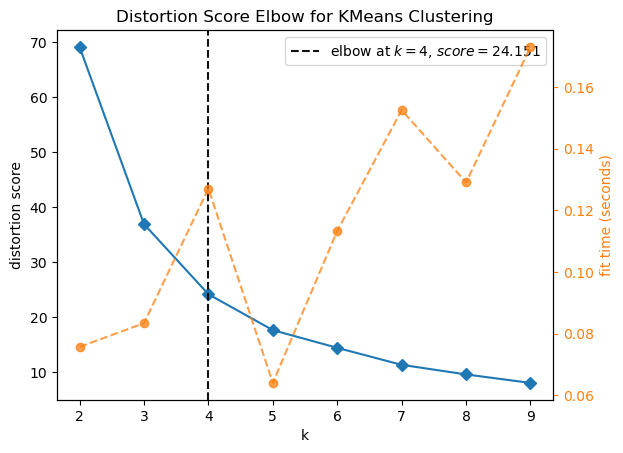

In [11]:
yellow = KMeans(random_state=0, n_init=10)
visualizer = KElbowVisualizer(yellow, k=(2,10))
visualizer.fit(X)
visualizer.show()
plt.show()

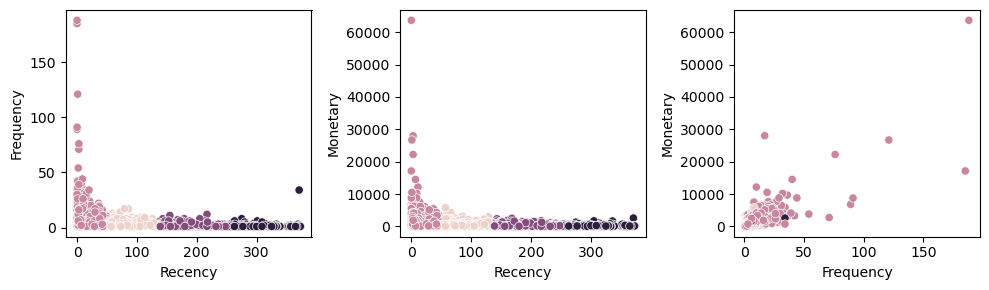

In [12]:
model = KMeans(n_clusters=visualizer.elbow_value_, random_state=0, init='k-means++', n_init=1)
fitted = model.fit(X)
RFM['Label'] = fitted.labels_


fig, axs = plt.subplots(1,3, figsize=(10,3))

sns.scatterplot(RFM, x='Recency', y='Frequency', hue='Label', ax=axs[0])
sns.scatterplot(RFM, x='Recency', y='Monetary', hue='Label', ax=axs[1])
sns.scatterplot(RFM, x='Frequency', y='Monetary', hue='Label', ax=axs[2])

[ax.legend([], frameon=False) for ax in axs]
plt.tight_layout()
plt.show()

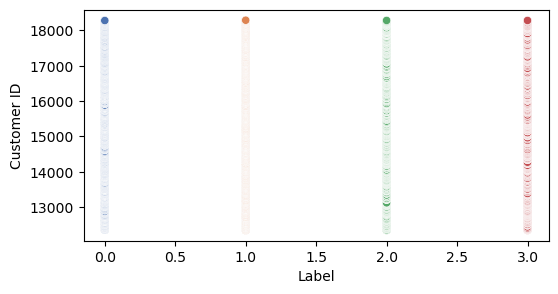

In [13]:
sns.scatterplot(RFM, x='Label', y=RFM.index, hue='Label', palette='deep')
plt.legend([], frameon=False)
plt.gcf().set_size_inches(6,3)
plt.show()

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

In [14]:
cgc = RFM.groupby('Label').size().rename('Size').to_frame()
cgm = RFM.groupby('Label').mean()
customer_groups = cgc.join(cgm)
customer_groups

,Size,Recency,Frequency,Monetary
Label,,,,
0,1028,79.779183,2.478599,515.633113
1,2016,18.645337,5.854663,1191.025918
2,613,190.086460,1.817292,297.053736
3,474,308.025316,1.305907,200.548776


<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

In [15]:
# clusters = RFM[['Label']].reset_index()
# clusters.to_csv('data/online_retail_clean_clusters.csv', index=False)

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>